In [12]:
from os import path
import glob
import time

# Third-party
from astropy.table import Table, join, hstack
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm

import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData

In [2]:
tbl = ascii.read('/Users/adrian/data/Misc/Vasiliev-globclust.txt', 
                 format='fixed_width')

tbl = tbl[np.isfinite(tbl['D']) & np.isfinite(tbl['Vlos'])]
n_clusters = len(tbl)

In [3]:
mw_pot = gp.Hamiltonian(gp.load('../../gd1-dr2/output/mwpot.yml'))
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)

# corresponds to phi1=-40º, phi2~0º at present day
gd1_w0 = gd.PhaseSpacePosition(pos=[-12.68868135, -0.6431087,  6.07148769]*u.kpc,
                               vel=[-0.08122873, -0.24523054, -0.12486828]*u.kpc/u.Myr)

## First reproduce Ana's figure

In [4]:
orbit_kw = dict(dt=-0.2*u.Myr, t1=0*u.Myr, t2=-1*u.Gyr)

In [5]:
mean_c = coord.SkyCoord(ra=tbl['RA']*u.deg,
                        dec=tbl['DEC']*u.deg,
                        distance=tbl['D']*u.kpc,
                        pm_ra_cosdec=tbl['PMRA']*u.mas/u.yr,
                        pm_dec=tbl['PMDEC']*u.mas/u.yr,
                        radial_velocity=tbl['Vlos']*u.km/u.s)

In [6]:
gd1_orbit = mw_pot.integrate_orbit(gd1_w0, **orbit_kw)

gc_w0 = gd.PhaseSpacePosition(mean_c.transform_to(gc_frame).cartesian)
orbits = mw_pot.integrate_orbit(gc_w0, **orbit_kw)

mean_dr = (orbits.pos - gd1_orbit.pos[:, None]).norm()
mean_dr.shape

(5001, 147)

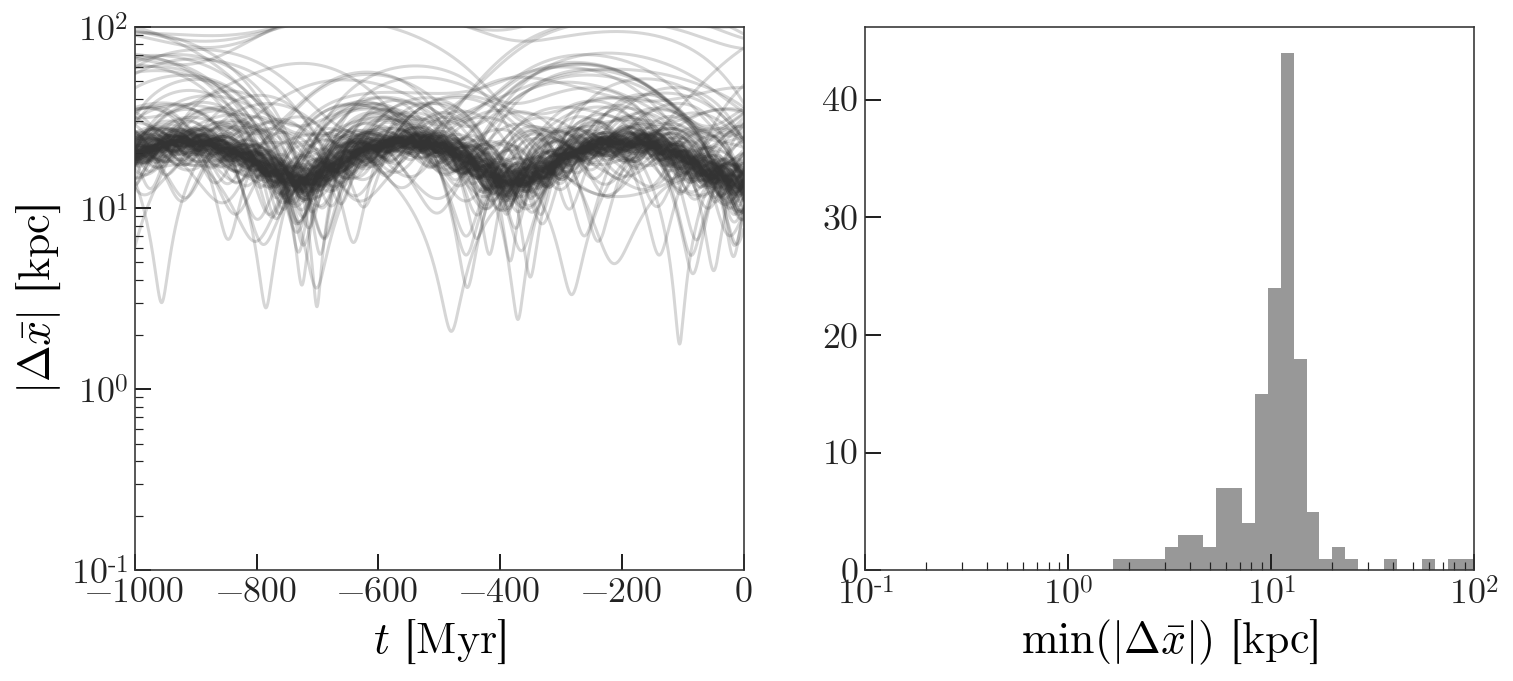

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.plot(orbits.t, mean_dr, 
        marker='', color='#333333', alpha=0.2);

# squiggly line are the bulge globular clusters
# ax.plot(orbits.t, mean_dr[:, (gc_w0.pos.norm() < 4*u.kpc)], 
#         marker='', color='#333333', alpha=0.2);
ax.set_yscale('log')
ax.set_xlim(-1000, 0)
ax.set_ylim(1e-1, 1e2)
ax.set_xlabel('$t$ [Myr]')
ax.set_ylabel(r'$|\Delta \bar{x}|$ [kpc]')

ax = axes[1]
bins = np.logspace(-2, 2, 64)
ax.hist(mean_dr.to(u.kpc).value.min(axis=0), 
        bins=bins, color='#333333', alpha=0.5)
ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)
ax.set_xlabel(r'${\rm min}(|\Delta \bar{x}|)$ [kpc]');

fig.set_facecolor('w')

---

## Repeat for orbit samples

In [8]:
off = tbl['corrPM']*tbl['ePMRA']*tbl['ePMDEC']
cov = np.array([[tbl['ePMRA']**2, off],
                [off, tbl['ePMDEC']**2]])

n_samples = 128
pm_samples = np.array([np.random.multivariate_normal([tbl['PMRA'][n], tbl['PMDEC'][n]], cov[..., n], n_samples) 
                       for n in range(len(tbl))])
pmra, pmdec = pm_samples.T

In [9]:
c_samples = coord.SkyCoord(
    ra=tbl['RA'][None]*u.deg,
    dec=tbl['DEC'][None]*u.deg,
    distance=np.random.normal(tbl['D'], 0.05*tbl['D'], size=(n_samples, n_clusters))*u.kpc,
    pm_ra_cosdec=pmra*u.mas/u.yr,
    pm_dec=pmdec*u.mas/u.yr,
    radial_velocity=np.random.normal(tbl['Vlos'], tbl['eVlos'], (n_samples, n_clusters))*u.km/u.s)

In [10]:
gc_w0 = gd.PhaseSpacePosition(c_samples.transform_to(gc_frame).cartesian)

In [13]:
min_dr = []
for n in tqdm(range(n_clusters)):
    name = tbl[n]['Name']
    orbit_samples = mw_pot.integrate_orbit(gc_w0[:, n], **orbit_kw)
    
    dr = (orbit_samples.pos - gd1_orbit.pos[:, None]).norm()
    min_dr.append(dr.min(axis=0))
    
min_dr = u.Quantity(min_dr)

100%|██████████| 147/147 [00:29<00:00,  5.02it/s]


100%|██████████| 147/147 [00:24<00:00,  6.04it/s]


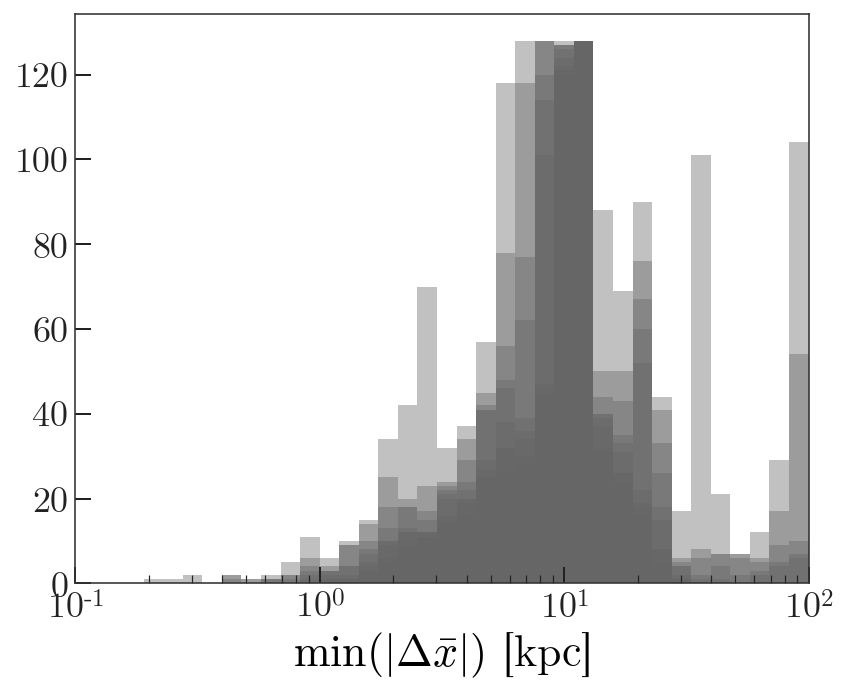

In [14]:
bins = np.logspace(-2, 2, 51)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

for n in tqdm(range(n_clusters)):
    ax.hist(min_dr.to(u.kpc).value[n], 
            bins=bins, color='#666666', alpha=0.4)

ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)
ax.set_xlabel(r'${\rm min}(|\Delta \bar{x}|)$ [kpc]');
fig.set_facecolor('w')
fig.tight_layout()